# 01-EDA-and-mask-saving. 
This notebooks is a combination of https://www.kaggle.com/code/awsaf49/uwmgi-mask-data and https://www.kaggle.com/code/clemchris/create-numpy-masks

In [1]:
%load_ext autoreload
%autoreload 2

import gi_tract_seg as gts
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import glob
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import cv2
import seaborn as sns

tqdm.pandas()

In [2]:
def save_mask_by_id(id_, image_folder, mask_folder):
    idf = df[df['id'] == id_]
    gts.data.utils.save_mask(idf, image_folder, mask_folder)

In [3]:
processed_masks_folder = '../data/processed/masks/'
images_folder = '../data/raw/train/'
train_annotation_path = '../data/raw/train.csv'

## Prepare and save masks

### Load annotation

In [4]:
df = pd.read_csv(train_annotation_path)
df = df.progress_apply(gts.data.utils.get_metadata, axis=1)
df.head()

  0%|          | 0/115488 [00:00<?, ?it/s]

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1
2,case123_day20_slice_0001,stomach,NaN,123,20,1
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2


### Get paths

In [5]:
paths = glob.glob(f'{images_folder}/*/*/*/*')
path_df = pd.DataFrame(paths, columns=['image_path'])
path_df = path_df.progress_apply(gts.data.utils.path2info, axis=1)
df = df.merge(path_df, on=['case','day','slice'])
df.head()

  0%|          | 0/38496 [00:00<?, ?it/s]

,id,class,segmentation,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,../data/raw/train/case123/case123_day20/scans/...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,../data/raw/train/case123/case123_day20/scans/...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,1,../data/raw/train/case123/case123_day20/scans/...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,../data/raw/train/case123/case123_day20/scans/...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,../data/raw/train/case123/case123_day20/scans/...,266,266


### Vizualize 4 examples

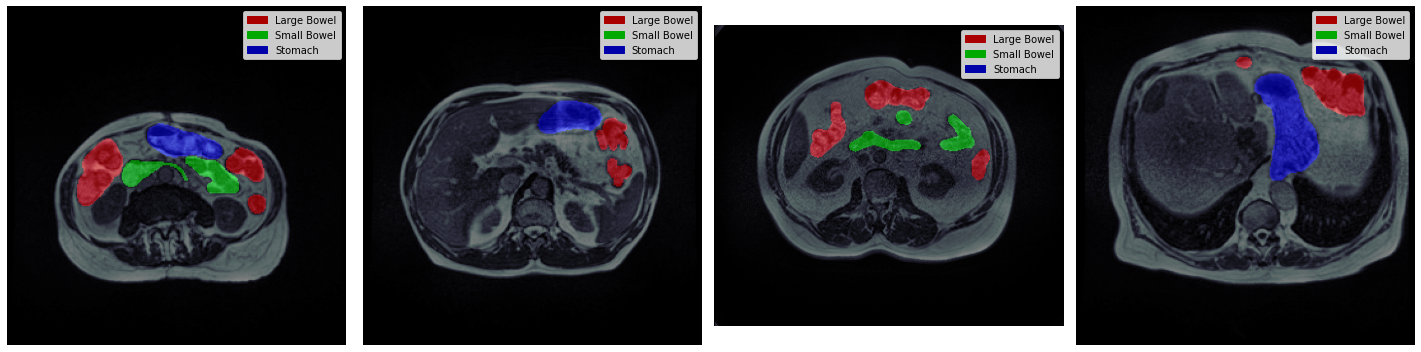

In [6]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
for i, id_ in enumerate(df[~df.segmentation.isna()].sample(frac=1.0)['id'].unique()[:row*col]):
    idf = df[df['id']==id_]
    img = gts.visualization.load_img(idf.image_path.iloc[0])
    mask = gts.data.utils.id2mask(idf)*255
    plt.subplot(row, col, i+1)
    i+=1
    gts.visualization.show_img(img, mask=mask)
    plt.tight_layout()

### Save every mask separately

In [7]:
ids = df['id'].unique()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask_by_id)(id_, images_folder, processed_masks_folder)\
                                             for id_ in tqdm(ids, total=len(ids)))

  0%|          | 0/38496 [00:00<?, ?it/s]

### Check that saved masks are correct

In [8]:
i = 250
# load saved mask
mask_path = df['image_path'].iloc[i].replace(images_folder,processed_masks_folder)
mask_loaded = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
# rle to mask
idf = df[df['id']==df.id.iloc[i]]
mask = gts.data.utils.id2mask(idf)
# compare
assert np.allclose(mask_loaded[...,0] - mask[..., 0], 0)

## EDA

In [9]:
train_df = gts.data.utils.merge_ids(df)

In [10]:
# quick test that we will always have the same order of classes
assert np.all([x == ['large_bowel', 'small_bowel', 'stomach'] for x in train_df['classes'].values])

### Add mask_path

In [11]:
train_df['mask_path'] =\
    [x.replace(images_folder, processed_masks_folder) for x in train_df.image_path.values]

### Look at distribution of mask sizes

<AxesSubplot:xlabel='variable', ylabel='value'>

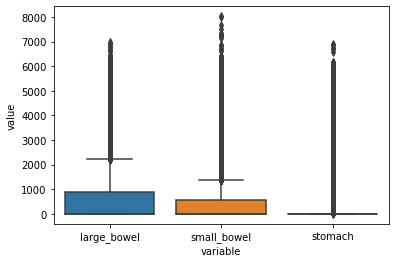

In [12]:
train_df['segmentation_sizes'] = gts.data.utils.compute_segmentation_sizes(train_df)

segmentation_sizes_df = pd.melt(pd.DataFrame(
    {
        'large_bowel': train_df['segmentation_sizes'].apply(lambda x: x[0]).values,
        'small_bowel': train_df['segmentation_sizes'].apply(lambda x: x[1]).values,
        'stomach': train_df['segmentation_sizes'].apply(lambda x: x[2]).values,
        'id': train_df['id'].values
    }
), id_vars='id', value_vars=['large_bowel', 'small_bowel', 'stomach'])

sns.boxplot(data=segmentation_sizes_df, y='value', x='variable')

In [13]:
train_df

,id,case,day,slice,image_path,height,width,classes,segmentation,labels,empty,mask_path,segmentation_sizes
0,case123_day20_slice_0001,123,20,1,../data/raw/train/case123/case123_day20/scans/...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case123/case123_day20/...,"[0.0, 0.0, 0.0]"
1,case123_day20_slice_0002,123,20,2,../data/raw/train/case123/case123_day20/scans/...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case123/case123_day20/...,"[0.0, 0.0, 0.0]"
2,case123_day20_slice_0003,123,20,3,../data/raw/train/case123/case123_day20/scans/...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case123/case123_day20/...,"[0.0, 0.0, 0.0]"
3,case123_day20_slice_0004,123,20,4,../data/raw/train/case123/case123_day20/scans/...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case123/case123_day20/...,"[0.0, 0.0, 0.0]"
4,case123_day20_slice_0005,123,20,5,../data/raw/train/case123/case123_day20/scans/...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case123/case123_day20/...,"[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,30,0,140,../data/raw/train/case30/case30_day0/scans/sli...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case30/case30_day0/sca...,"[0.0, 0.0, 0.0]"
38492,case30_day0_slice_0141,30,0,141,../data/raw/train/case30/case30_day0/scans/sli...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case30/case30_day0/sca...,"[0.0, 0.0, 0.0]"
38493,case30_day0_slice_0142,30,0,142,../data/raw/train/case30/case30_day0/scans/sli...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case30/case30_day0/sca...,"[0.0, 0.0, 0.0]"
38494,case30_day0_slice_0143,30,0,143,../data/raw/train/case30/case30_day0/scans/sli...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case30/case30_day0/sca...,"[0.0, 0.0, 0.0]"


We observe some differences in distribution of sizes for different classes

### Dataset balance

In [14]:
train_df['empty'].value_counts()

1    21906
0    16590
Name: empty, dtype: int64

Dataset is quite balanced on a level empty - non-empty images

### N cases and n slices \ n days

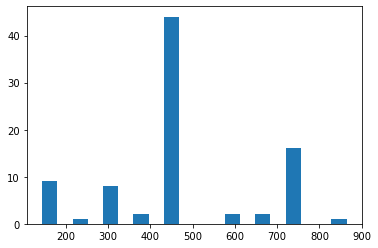

In [15]:
plt.hist(train_df['case'].value_counts(), bins=20);

Most cases have ~450 slices, but in general there are 4 modes: 150, 300, 750 and 450. Do we tend to have more cancer areas is cases with increased number of slices? (e.g the doctor had some suspicious and wanted to see more details)

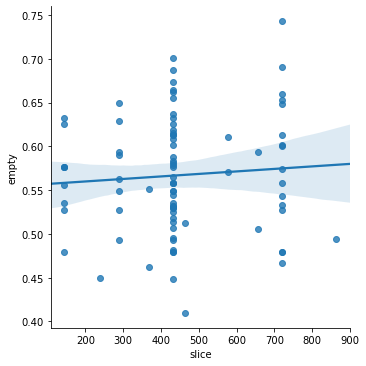

In [16]:
sns.lmplot(
    data = train_df.groupby(['case']).aggregate({'slice': 'size', 'empty': np.mean}),
    x = 'slice',
    y = 'empty',
    truncate = False
);

We don't see a particular trend here

### Make fold splits

In [17]:
train_df = gts.data.utils.create_folds(train_df, n_splits=5, random_seed=42)
train_df.head()

,id,case,day,slice,image_path,height,width,classes,segmentation,labels,empty,mask_path,segmentation_sizes,fold
0,case123_day20_slice_0001,123,20,1,../data/raw/train/case123/case123_day20/scans/...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case123/case123_day20/...,"[0.0, 0.0, 0.0]",3
1,case123_day20_slice_0002,123,20,2,../data/raw/train/case123/case123_day20/scans/...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case123/case123_day20/...,"[0.0, 0.0, 0.0]",3
2,case123_day20_slice_0003,123,20,3,../data/raw/train/case123/case123_day20/scans/...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case123/case123_day20/...,"[0.0, 0.0, 0.0]",3
3,case123_day20_slice_0004,123,20,4,../data/raw/train/case123/case123_day20/scans/...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case123/case123_day20/...,"[0.0, 0.0, 0.0]",3
4,case123_day20_slice_0005,123,20,5,../data/raw/train/case123/case123_day20/scans/...,266,266,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]","[0, 0, 0]",1,../data/processed/masks/case123/case123_day20/...,"[0.0, 0.0, 0.0]",3


In [18]:
train_df['fold'].value_counts()

1    8896
0    8864
3    7168
4    7088
2    6480
Name: fold, dtype: int64

In [19]:
train_df.to_parquet('../data/processed/train_df_agg.parquet')